# Sierra Leone Solar Data EDA
Exploratory Data Analysis for the Sierra Leone solar dataset.

In [15]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load the dataset
df = pd.read_csv('../data/solar-measurements_sierraleone-bumbuna_qc.csv', encoding='latin1', skiprows=[1])

In [6]:
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in key_columns:
    non_numeric = df[col][pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()]
    if not non_numeric.empty:
        print(f"Non-numeric values in {col}:\n", non_numeric.unique())

In [7]:
# Summary statistics
summary_stats = df.describe()
print(summary_stats)

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

In [8]:
# Missing values
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
print("Missing Values:\n", missing_values)
print("\nColumns with >5% missing values:\n", missing_percent[missing_percent > 5])

Missing Values:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns with >5% missing values:
 Comments    100.0
dtype: float64


In [10]:
# Compute Z-scores
z_scores = df[key_columns].apply(zscore, nan_policy='omit')
# Flag outliers (|Z| > 3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of rows with outliers: {outliers.sum()}")

Number of rows with outliers: 16292


In [12]:
# Drop columns with >50% missing values
df = df.loc[:, df.isna().mean() < 0.5]

In [13]:
# Export cleaned data
df.to_csv('../data/sierraleone_clean.csv', index=False)

In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

C:\Users\naomi.DESKTOP-T924HPN\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


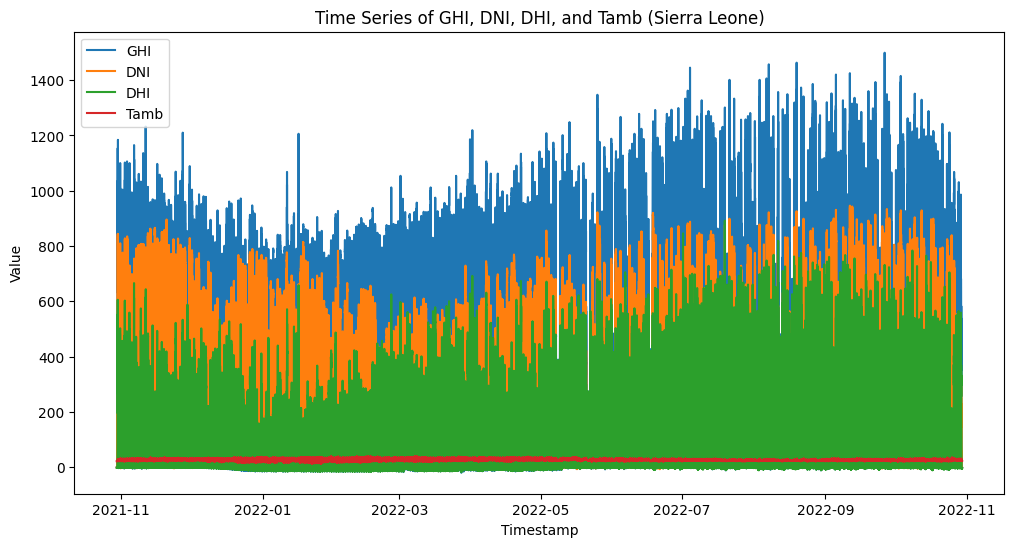

In [16]:

# Line plots
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI')
plt.plot(df['Timestamp'], df['DNI'], label='DNI')
plt.plot(df['Timestamp'], df['DHI'], label='DHI')
plt.plot(df['Timestamp'], df['Tamb'], label='Tamb')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of GHI, DNI, DHI, and Tamb (Sierra Leone)')
plt.legend()
plt.show()

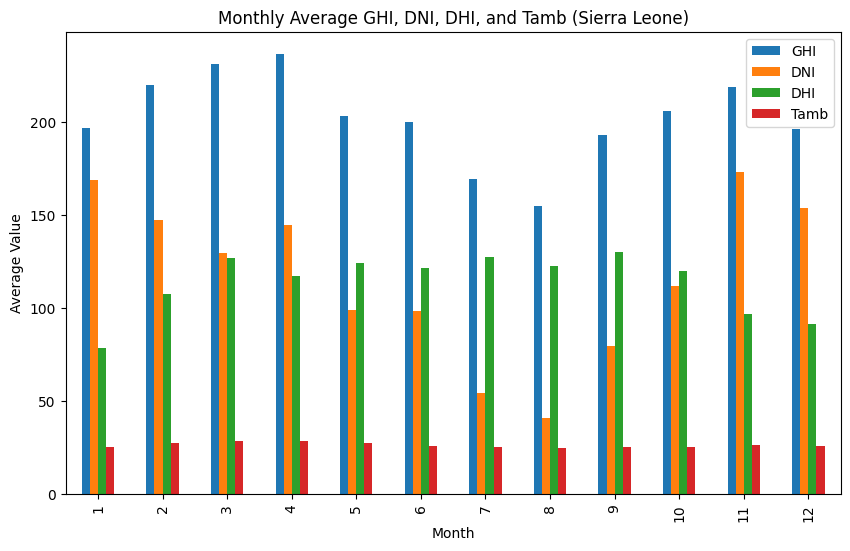

In [17]:
df['Month'] = df['Timestamp'].dt.month
monthly_stats = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Create bar chart for monthly averages
monthly_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average GHI, DNI, DHI, and Tamb (Sierra Leone)')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.show()

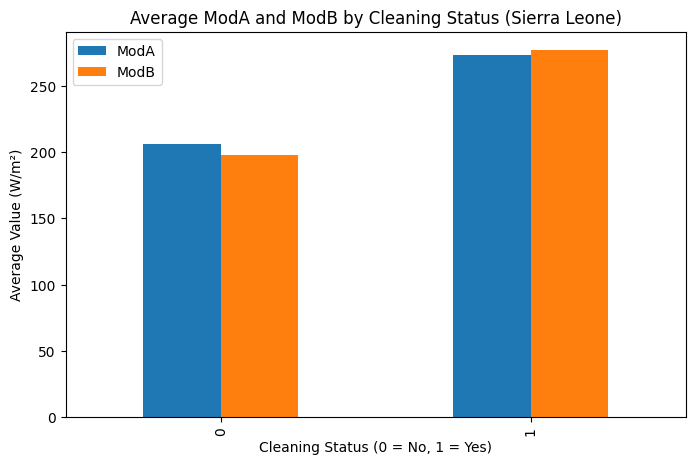

In [18]:
# Group by Cleaning flag and calculate average ModA and ModB
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot bar chart
cleaning_impact.plot(kind='bar', figsize=(8, 5))
plt.title('Average ModA and ModB by Cleaning Status (Sierra Leone)')
plt.xlabel('Cleaning Status (0 = No, 1 = Yes)')
plt.ylabel('Average Value (W/m²)')
plt.show()

Cleaning events improve ModA and ModB readings, indicating reduced soiling effects.